# Tracking Objects captured in the Initial Frame using the YOLO Algorithm

Importing the relevant modules

In [1]:
import cv2
import sys
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

The YOLOv3 will be used to perform object detection.  
  
The yolov3.cfg file was downloaded containing the network architecture used by YOLOv3.  
(source: https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg)

Similarly, the yolov3.weights file was downloaded , containing the pre-trained weights.  
(wget https://pjreddie.com/media/files/yolov3.weights)

Finally, the coco.names file, containing the list of 80 object classes was downloaded, which corresponds to the objects that the weights were trained to detect.  
(source: https://github.com/pjreddie/darknet/blob/master/data/coco.names)

In [2]:
# Set the location and name of the cfg file
cfg_file = './cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './weights/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = './data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

In [3]:
#Printing the network using the .print_network() function
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

### Capturing the first frame from Video Input
  
Reading video input from the webcam.

As seen in the previous cell, the input size of the first layer of the network is 416 x 416 x 3.
  
Thus, the image needs to be resized compatible with the input size of the first layer in the network.  

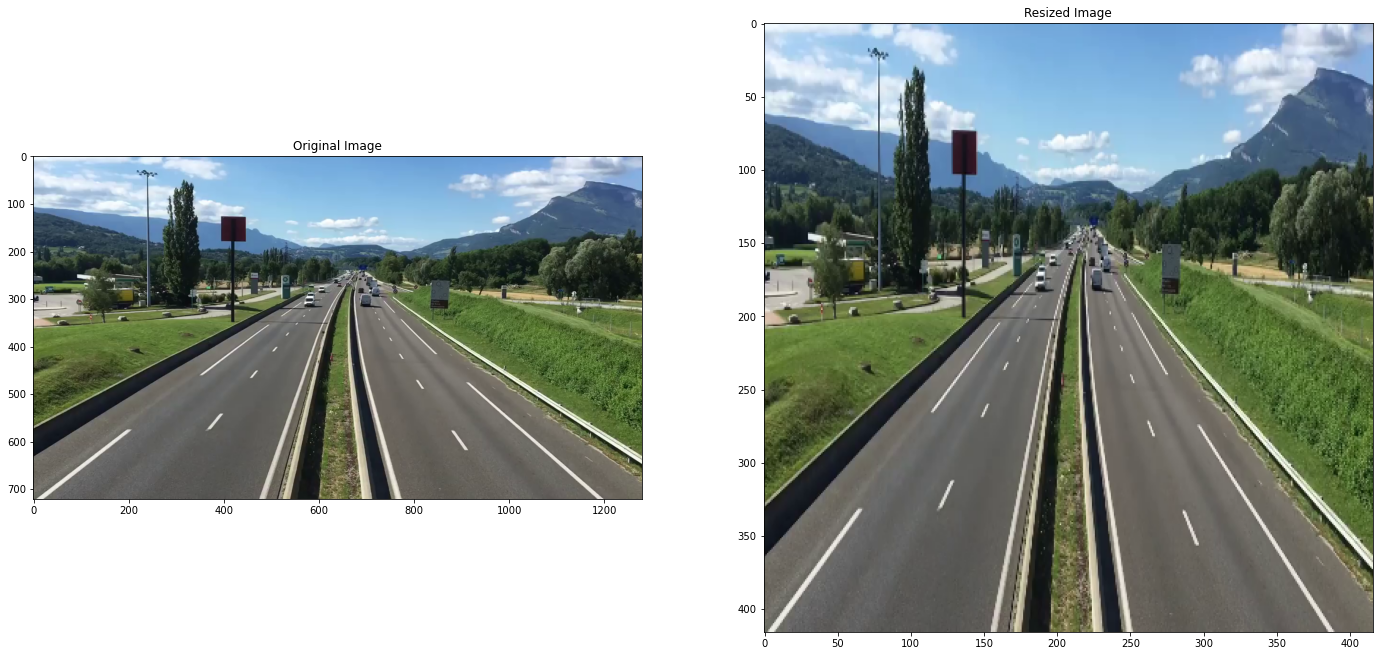

In [4]:
# Reading video from webcam
video_path="./Videos/Highway Traffic.mp4"
video = cv2.VideoCapture(video_path)

# Attempting to reopen the video if video not opened.
if not video.isOpened():
    print ("Could not open video. Attempt to re-open")
    video.open(video_path)

# Reading the first frame 
ok, frame = video.read()
if not ok:
    print ('Cannot read video')
    sys.exit()
    
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Convert the image to RGB
original_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

cv2.destroyAllWindows()
video.release()

### Setting the Non-Maximal Suppression and  Threshold

Since YOLO uses the **Non-Maximal Suppression (NMS)**, to only keep the best bounding box, the NMS Threshold is set to 0.6

The IOU threshold is set to 0.4

Thus, all predicted bounding boxes that have an IOU value greater than 0.4 with respect to the best bounding boxes will be removed.


In [5]:
# Sets the NMS threshold
nms_thresh = 0.6

# Set the IOU threshold
iou_thresh = 0.4

# Object Detection

Objects Found and Confidence Level:

1. car: 0.998725
2. car: 0.845372
3. car: 0.984095
4. car: 0.998701


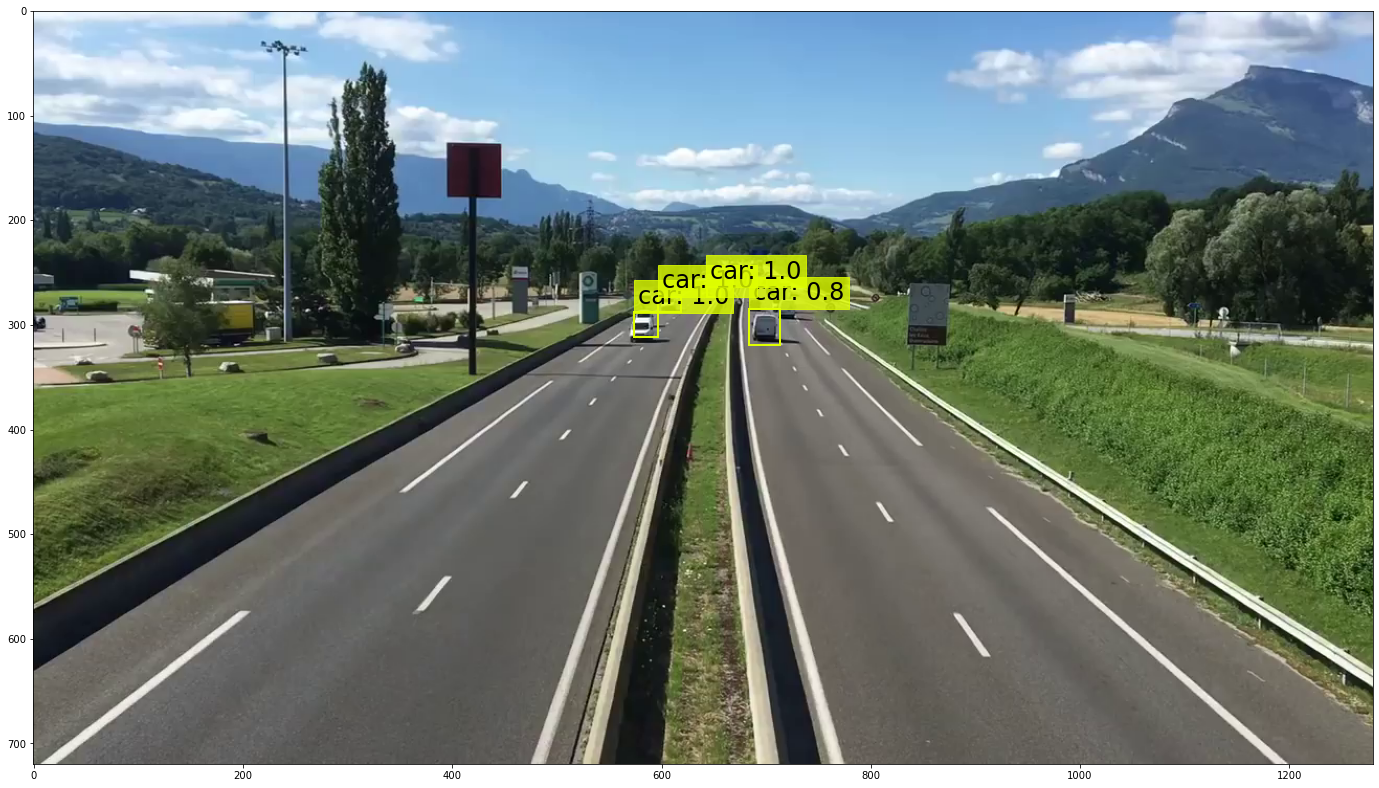

[(574, 288, 23, 24), (684, 285, 29, 34), (597, 273, 22, 15), (643, 264, 13, 9)]


In [6]:
# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

bboxes=get_box_coordinates(original_image, boxes, class_names, plot_labels=True)

print(bboxes)

## Putting together the YOLO Detector and the Tracker

In [7]:
trackerTypes = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

def createTrackerByName(trackerType):
    # Create a tracker based on tracker name
    if trackerType == trackerTypes[0]:
        tracker = cv2.TrackerBoosting_create()
    elif trackerType == trackerTypes[1]: 
        tracker = cv2.TrackerMIL_create()
    elif trackerType == trackerTypes[2]:
        tracker = cv2.TrackerKCF_create()
    elif trackerType == trackerTypes[3]:
        tracker = cv2.TrackerTLD_create()
    elif trackerType == trackerTypes[4]:
        tracker = cv2.TrackerMedianFlow_create()
    elif trackerType == trackerTypes[5]:
        tracker = cv2.TrackerGOTURN_create()
    elif trackerType == trackerTypes[6]:
        tracker = cv2.TrackerMOSSE_create()
    elif trackerType == trackerTypes[7]:
        tracker = cv2.TrackerCSRT_create()
    else:
        tracker = None
        print('Incorrect tracker name')
        print('Available trackers are:')
        for t in trackerTypes:
            print(t)
    return tracker

In [8]:
# Create MultiTracker object
tracker_type = "KCF"
# Create MultiTracker object
multiTracker = cv2.MultiTracker_create()

# Initialize MultiTracker 
for bbox in bboxes:
    multiTracker.add(createTrackerByName(tracker_type), frame, bbox)

# Reading video from webcam
video = cv2.VideoCapture(video_path)

# Attempting to reopen the video if video not opened.
if not video.isOpened():
    print ("Could not open video. Attempt to re-open")
    video.open(video_path)

while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break
        
    # Start timer
    timer = cv2.getTickCount()

    
    # get updated location of objects in subsequent frames
    ok, boxes = multiTracker.update(frame)
    #print(ok)

     # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # draw tracked objects
    if ok:
        for i, newbox in enumerate(boxes):
            p1 = (int(newbox[0]), int(newbox[1]))
            p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
            cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    
    if not ok:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display tracker type on frame
    cv2.putText(frame, tracker_type + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);
    
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    # show frame
    cv2.imshow('MultiTracker', frame)
  
    # quit on ESC button
    if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
        break
        
cv2.destroyAllWindows()
video.release()